In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("TitleDataSet\clickbait_data.csv")

In [3]:
df.groupby('clickbait').size()

clickbait
0    16001
1    15999
dtype: int64

In [3]:
embeddings_index = {}
f = open('TitleDataSet\glove.6B.100d.txt',encoding="utf")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [4]:
df

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [5]:
features = df['headline']
labels = df['clickbait']

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2)

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.values)
sequences = tokenizer.texts_to_sequences(X_train.values)
sequences = sequence.pad_sequences(sequences, maxlen=200)

In [8]:
sequences.shape


(25600, 200)

In [9]:
max_words = 22736
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [10]:
baseModel = Input(shape=(None,), dtype='int32', name='headline_input')
headModel = layers.Embedding(22736, 100, input_length=200)(baseModel)
headModel = layers.LSTM(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True)(headModel)
headModel = layers.LSTM(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=False)(headModel)
headModel = layers.Dense(100, activation='relu')(headModel)
headModel = layers.Dense(1, activation='sigmoid')(headModel)
model = Model(baseModel,headModel)
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 headline_input (InputLayer)  [(None, None)]           0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2273600   
                                                                 
 lstm (LSTM)                 (None, None, 32)          17024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 100)               3300      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,302,345
Trainable params: 28,745
Non-trainabl

In [12]:
history = model.fit(sequences, Y_train.values, epochs=5, validation_split=0.2)

Epoch 1/5
640/640 [==============================] - 144s 215ms/step - loss: 0.1617 - acc: 0.9402 - val_loss: 0.1141 - val_acc: 0.9568
Epoch 2/5
640/640 [==============================] - 141s 220ms/step - loss: 0.1070 - acc: 0.9599 - val_loss: 0.1109 - val_acc: 0.9549
Epoch 3/5
640/640 [==============================] - 134s 210ms/step - loss: 0.0862 - acc: 0.9686 - val_loss: 0.0737 - val_acc: 0.9723
Epoch 4/5
640/640 [==============================] - 123s 192ms/step - loss: 0.0732 - acc: 0.9724 - val_loss: 0.0696 - val_acc: 0.9746
Epoch 5/5
640/640 [==============================] - 132s 206ms/step - loss: 0.0651 - acc: 0.9762 - val_loss: 0.0689 - val_acc: 0.9750


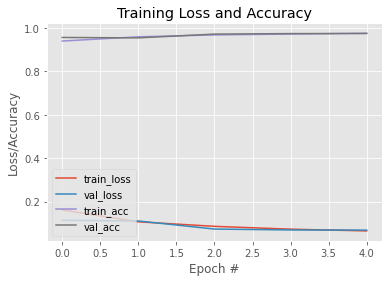

In [30]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 5), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 5), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, 5), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [16]:
sequences = tokenizer.texts_to_sequences(X_test.values)
sequences = sequence.pad_sequences(sequences, maxlen=200)
X_test = sequences

In [17]:
model.evaluate(X_test, Y_test.values, batch_size=200, verbose=2)    #[0.06678809970617294, 0.9756249785423279]

32/32 - 4s - loss: 0.0666 - acc: 0.9739 - 4s/epoch - 116ms/step


[0.0665682777762413, 0.9739062786102295]

In [21]:
with open('titletokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
def predict(text):
    txt = tokenizer.texts_to_sequences([text])
    txt = sequence.pad_sequences(txt, maxlen=200)
    pred = (model.predict(txt))
    print(pred)

In [27]:
predict("This will make your life easier")

[[0.9450431]]


In [29]:
predict("This is how I Cracked AMAZON Off-Campus Interview!!!")

[[0.9948083]]


In [25]:
predict("You will never feel the same")

[[0.99685585]]


In [26]:
predict("Cracked AMAZON Off-Campus Interview!!!")

[[0.01242959]]
